## Identifying Biases in Standardized Tests.

# Introduction: 
Our goal here is to identify whether SAT tests have some sort of bias towards people of certain demographics. The fairness of standardized testing has been a topic of debate for a while now and what this analysis looks to give insight to where this unfairness play a role. For the purpose of this analysis we will be looking at schools in New York.
We are going to be working with 8 data sets, some of the data included are:
* `ap_2010.csv`: This contains data on AP tests enrollment.
* `demographics.csv`: This contains data on the different demographics of people in NY high scools.
* `sat_results`: This contains data on the average SAT scores of different schools in New Yrok.

# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    ### uses the regex pattern to extract the latitude
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    ### uses the regex pattern to extract the longitude
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

In [12]:
survey_correlation = combined.corr()["sat_score"][survey_fields]

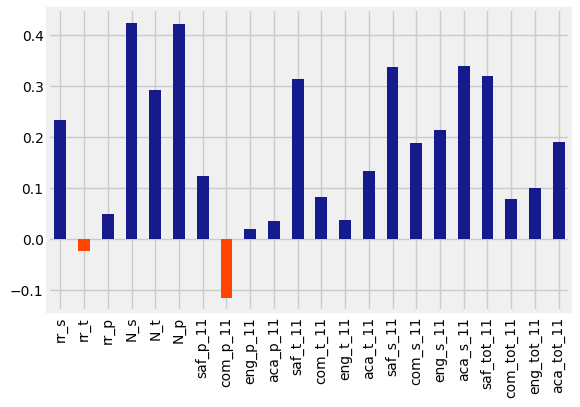

In [13]:
#returns a bar plot of the r values between different survey response and SAT scores
positive_corr = survey_correlation > 0
corr_map = positive_corr.map({True:'#151b8d', False:'#ff4500'})
survey_correlation.plot(kind='bar', legend=False, color=corr_map)
plt.show()

One of the most imteresting things that we can find from our correlation plot is that SAT scores correlated most with the number of student respondents(N_s),  number of parent respondents(N_P), safetfy and respect score based on student response(saf_s_11), safety and respect score based on teachers response(saf_t_11) and academic expectation score based on student responses(aca_s_11).

# Exploring Correlation between SAT Score and Safety Score

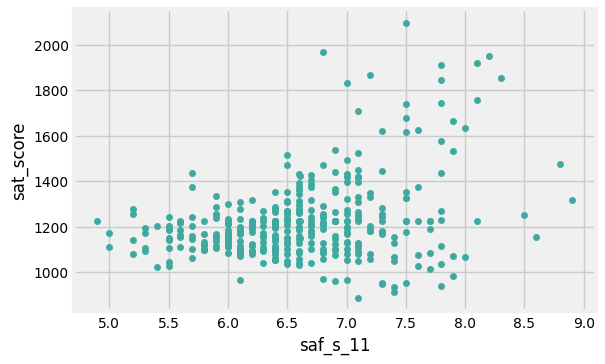

In [14]:
combined.plot.scatter(x='saf_s_11', y='sat_score', c='#3ea99f')
plt.show()

Looking at  our plot there doesn't seem to be a very strong correlation between the safety score and SAT scores.

# Grouping Data by Boroughs

In [15]:
#groups data by a specific column
boroughs = combined.groupby('boro').agg(np.mean)

In [16]:
boro_safety = boroughs['saf_s_11']

In [17]:
boro_safety

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Manhattan, Quuens and Bronx seem to have the highest average safety score amongst all of the boroughs in New York.

# Correlation with Race 

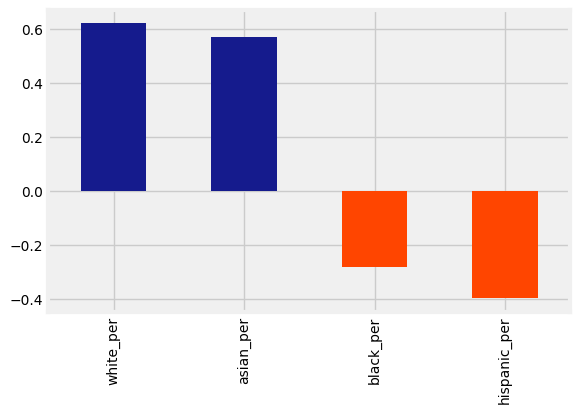

In [18]:
#returns a bar plot of the r values between race and SAT scores
race_col = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_corr = combined.corr()['sat_score'][race_col]
positive_corr = combined.corr()['sat_score'][race_col] > 0
corr_map = positive_corr.map({True:'#151b8d', False:'#ff4500'})
race_corr.plot(kind='bar', color=corr_map)
plt.show()

Looking at our bar plot, we can see that both the white percentage and the Asian percentage has a strong positive correlation with the SAT scores while the black and especially the Hispanic percentage has a high negative correlation with the SAT scores.

# Exploring Hispanic Percentages

In [19]:
#returns result for schools with > 60% hispanic and average SAT socres less than 1000
hispanic_filt = (combined['hispanic_per'] >= 60) & (combined['sat_score'] < 1000)
hispanic_low_sat = combined[hispanic_filt]
hispanic_low_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
91,07X334,INTERNATIONAL COMMUNITY HIGH SCHOOL,34,310.0,324.0,311.0,945.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"345 Brook Avenue\nBronx, NY 10454\n(40.8100361...",40.810036,-73.917812,07
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
126,09X403,BRONX INTERNATIONAL HIGH SCHOOL,49,314.0,312.0,339.0,965.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",40.827603,-73.904475,09
139,10X268,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,52,304.0,356.0,302.0,962.0,Kingsbridge International High School,32.000000,37.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
179,12X550,HIGH SCHOOL OF WORLD CULTURES,42,304.0,323.0,312.0,939.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


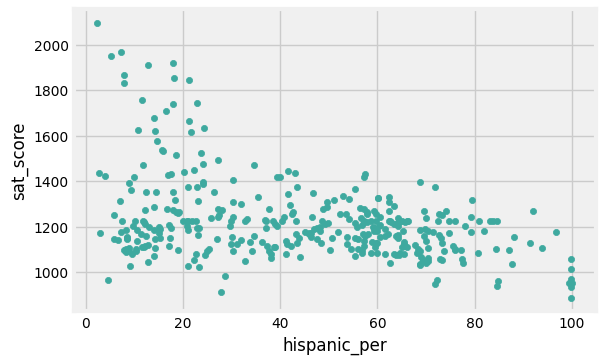

In [20]:
#shows a scatter plot of the hispanic percetage and SAT scores
combined.plot.scatter('hispanic_per', 'sat_score', c='#3ea99f')
plt.show()


Our scatter plot confirms the negative correlation between the hispanic percentages and SAT scores. Schools with lower hispanic percentages tend to have higher SAT scores. No school with over 60% of hispanic students have an SAT score up to 1600.

In [21]:
#returns schools with more than 95% hispanics
filt = combined['hispanic_per'] > 95
hispanic_more_than_95 = combined[filt]
hispanic_more_than_95['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

One thing common about the schools with over 95% of hisoancic students is that they all have a high percentage of minority enrollments. Usually 98% or more minority enrolllments  

In [22]:
#returns the result of schools with less than 10% hispanic and SAT scores > 1800
filt = (combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)
low_hisp_high_sat = combined[filt]
low_hisp_high_sat['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

For the sschools with less than 10% hispanic, What I have found out is that they are all part of the top 10 schools in New York snd these schools are generally geared towards sciences, This may Explain the high SAT scores. Although this schools have lower minority enrolment than schools with 95% hispanic, the difference is not as noticable as that of the economically disadvantaged people enrolled in these schools. Where schools with more than 95% hispanic had an economically disadvantaged enrollment of more than 90%, the schools with less than 10% hispanic on the other hand did not have an economically disadvantaged enrollment of more than 62%. So it is safe to infer that the rate of economically disadvantaged students enrolled in a school plays a part in why there are school's with a lot of hispanics and others with not so much.

# Correlation with Gender

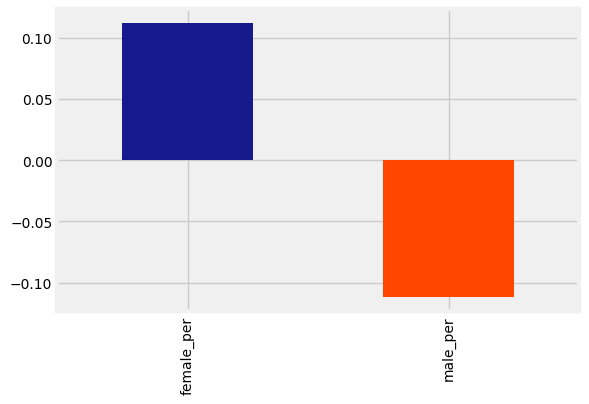

In [23]:
#returns a bar plot of the r values between gender and SAT scores
gender_col = ['female_per', 'male_per']
gender_corr = combined.corr()['sat_score'][gender_col]
positive_corr = combined.corr()['sat_score'][gender_col] > 0
corr_map = positive_corr.map({True:'#151b8d', False:'#ff4500'})
gender_corr.plot.bar(color=corr_map)
plt.show()


Although the r values do not show strong correlations, the male percentage correlates negatively with SAT scores while the female percentage correlates positively with SAT scores.

# Exploring Female percentages

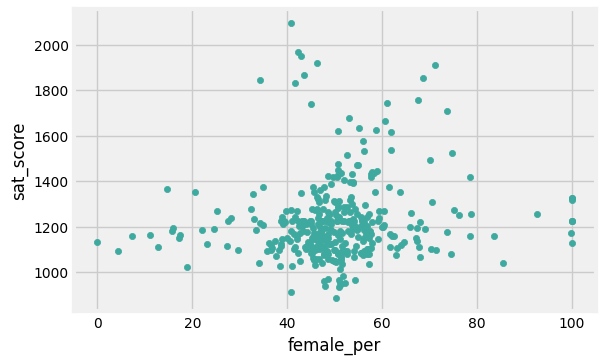

In [24]:
#displays a scatter plot showing the correlation between female percentage and SAT scores
combined.plot.scatter('female_per', 'sat_score', c='#3ea99f')
plt.show()

Our scatter plot shows us that there are little to no correlation between the female percentage and the SAT scores

In [25]:
#returns schools with more than 60% female and SAT scores greater than 1700
filt = (combined['female_per'] > 60) & (combined['sat_score'] > 1700)
high_female_high_sat = combined[filt]
high_female_high_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The most common thing about these schools is the low enrollment rate for the economically challenged. They also seem to be more of liberal arts schools

# Correlation with Advanced Placement(AP) Exams

In [26]:
#creates a new column with the AP percentages
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment'] * 100

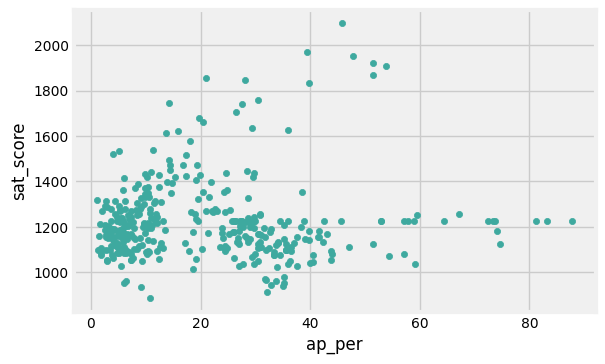

In [27]:
#displays a scatter plot showing the correlation between AP percentages and SAT scores
combined.plot.scatter('ap_per', 'sat_score', c='#3ea99f')
plt.show()

Our scatter plot shows us that there is little to no correlation between AP scores and SAT scores

# Correlation with Class Size

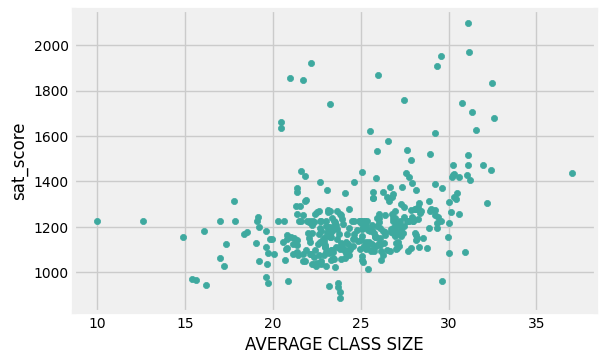

In [28]:
#displays a scatter plot showing the correlayion between SAT scores and class size.
combined.plot.scatter('AVERAGE CLASS SIZE', 'sat_score', c='#3ea99f')
plt.show()

Our plot shows us that there is also little to no correlation between class size and SAT scores.

# Assigning Points to School
We are going to assign points to school based on how well they perform in SAT tests. There is going to be a total of 5 points. Schools with SAT scores above 1800 will get 5 points, while those with 1400 to 1800 wil get 4 points. Scores between 1200 to 1400 gets 3points, scores between 1000 to 1200 gets 2 points and scores below 1000 get 1 point.

In [29]:
def point(val):
    ###assigns points based on SAT scores
    if val >= 1600:
        return 5
    elif val >= 1300 < 1600:
        return 4
    elif val >= 1200 < 1400:
        return 3
    elif val >= 1000 < 1200:
        return 2
    else:
        return 1

In [30]:
combined['sat_points'] = combined['sat_score'].apply(point)

In [31]:
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per,sat_points
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,30.575556,2
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,9.898477,2
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,3.177258,2
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,35.157724,3
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,15.809051,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,32K545,EBC HIGH SCHOOL FOR PUBLIC SERVICE–BUSHWICK,88,384.0,409.0,361.0,1154.0,EBC-HS FOR PUB SERVICE (BUSH),47.000000,64.000000,...,0,0.0,0.0,0.0,"1155 Dekalb Avenue\nBrooklyn, NY 11221\n(40.69...",40.694482,-73.929154,32,7.755776,2
359,32K549,BUSHWICK SCHOOL FOR SOCIAL JUSTICE,75,348.0,353.0,334.0,1035.0,0,129.028846,197.038462,...,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,29.730149,2
360,32K552,ACADEMY OF URBAN PLANNING,67,342.0,364.0,354.0,1060.0,Academy of Urban Planning,76.000000,100.000000,...,0,0.0,0.0,0.0,"400 Irving Avenue\nBrooklyn, NY 11237\n(40.696...",40.696962,-73.910816,32,19.095477,2
361,32K554,ALL CITY LEADERSHIP SECONDARY SCHOOL,39,428.0,465.0,422.0,1315.0,All City Leadership Secondary School,7.000000,8.000000,...,Then to New York City residents,0.0,0.0,0.0,"321 Palmetto Street\nBrooklyn, NY 11237\n(40.6...",40.697408,-73.913153,32,2.661597,4


# Average School Points per Borough

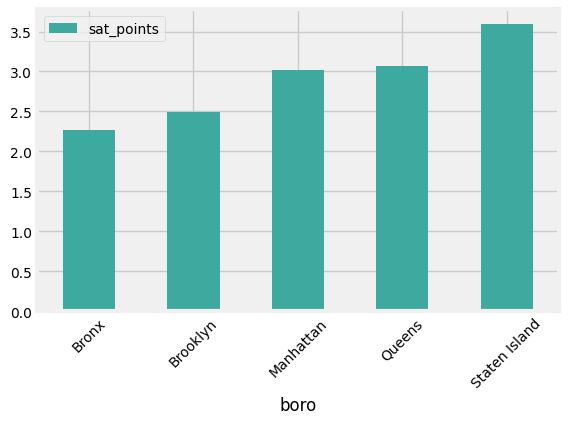

In [32]:
#displays a bar plot of the average school points for schools in each borough
boro_pvt = combined.pivot_table(index='boro', values='sat_points')
boro_pvt.plot.bar(rot=45, color='#3ea99f')
plt.show()

We can see from our plot that Staten Island is the borough with the most high performing schools on SATs while Bronx is the borough with the least performing schools on SATs.

# Conclusion
Our goal initially in this analysis is to uncover whether standardized tests like the SATs has some sort of bias towards certain demographics and to find the correlation bewteen these demographics and the SAT scores. So far we have found out the following:
1. There is a negative correlation between the percentage of hispanics and SAT scores in a school. While this looks to be a troubling trend, on futher investigation, we discovered that the schools which had low hispanic percentages and high sat scores were shcools with low enrollment for those with economical disadvantage. This could point to some kind of economic disparity between the hispanics and other demographics.

2. Suprisingly there wasn't a very strong correlation between SAT scores and gender, so one can conclude that there isn't any gender bias in the SAT scores.

3. There was also very little correlation between AP and SAT scores. ie: schools with high enrollment in AP tests didn't have any significant advantage over other schools

4. Of the  high schools in New York, the shcools  at Saten Island seemed to perform the best in SAT scores, followed by Queens, Manhattan, Brroklyn and lastly Bronx.